In [462]:
import os
os.environ['OMP_NUM_THREADS'] = '1'  # 设置环境变量以避免MKL内存泄漏
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from sklearn.model_selection import KFold, cross_val_score,cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import math
import plotly.graph_objs as go 
import plotly.express as px 
from plotly.offline import init_notebook_mode, plot 
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# 直接读取CSV文件
file_path = 'World_Happiness_Report_2024.csv'  # 替换为你的实际文件路径
df = pd.read_csv(file_path,encoding = 'gbk')

In [482]:
# 检查数据基本信息
print("\nDataset Info:")
print(df.describe())

# 检查缺失值情况
print("\n缺失值:\n", df.isnull().sum())


Dataset Info:
                年份         幸福指数      对数人均GDP         社会支持       预期健康寿命  \
count  2363.000000  2363.000000  2335.000000  2350.000000  2300.000000   
mean   2014.763860     5.483562     9.399673     0.809369    63.401828   
std       5.059436     1.125523     1.152062     0.121211     6.842644   
min    2005.000000     1.281271     5.526723     0.228217     6.720000   
25%    2011.000000     4.646750     8.506165     0.743811    59.195001   
50%    2015.000000     5.448725     9.502946     0.834395    65.099998   
75%    2019.000000     6.323592    10.392974     0.903779    68.552502   
max    2023.000000     8.018934    11.675588     0.987343    74.599998   

           选择生活的自由          慷慨度         腐败感知         正面影响         负面影响  
count  2327.000000  2282.000000  2238.000000  2339.000000  2347.000000  
mean      0.750290     0.000096     0.743959     0.651878     0.273160  
std       0.139366     0.161386     0.184871     0.106249     0.087133  
min       0.228301    -0.3

### 一. 初步填充数据

In [464]:
data = df.copy()

# 按国家分组
grouped = data.groupby('国家/地区')

# 初始化一个列表来存储处理后的数据
processed_data = []

def fill_missing_values(group):
    # 对每个需要处理的列进行线性插值
    for column in group.columns:
        if column not in ['国家/地区', '年份']:
            # 线性插值
            group[column] = group[column].interpolate(method='linear', limit_direction='both', inplace=False)
            
            # 如果该国家没有别的数据，就用所有国家的平均值填充
            if group[column].isnull().all():
                global_mean = data[column].mean()  # 全局平均值
                group[column] = global_mean
    
    return group
# 获取需要处理的列名（除去'Country name'和'year'）
columns_to_fill = [col for col in data.columns if col not in ['国家/地区', '年份']]

# 遍历每个国家并应用填充函数到所有需要处理的列
for country, group in grouped:
    group = fill_missing_values(group)
    processed_data.append(group)

# 将所有国家的数据合并回一个DataFrame
first_data = pd.concat(processed_data)

# 重置索引
first_data.reset_index(drop=True, inplace=True)

# 保存处理后的数据
first_data.to_csv('Processed_World_Happiness_Report_2024.csv', index=False)

print("数据初步填充完成.")

数据初步填充完成.


### 二.使用线性模型和随机森林初步预测判断优劣

In [466]:
# 选择特征和目标变量
X = first_data[['国家/地区','年份','幸福指数','对数人均GDP','社会支持','预期健康寿命','选择生活的自由','慷慨度','腐败感知','正面影响','负面影响']]
y = first_data['幸福指数']


# 设置K折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 模型字典
models = {
    '线性模型': LinearRegression(),
    '随机森林回归': RandomForestRegressor(n_estimators=16)
}

# 存储RMSE分数
rmse_scores = {}

# 对每个模型计算交叉验证分数
for model_name, model in models.items():
    # 计算交叉验证分数
    scores = cross_val_score(model, X_interpolated, y, cv=kf, scoring='neg_mean_squared_error')
    # 将MSE转换为RMSE
    rmse = math.sqrt(-scores.mean())
    rmse_scores[model_name] = rmse
    print(f"{model_name} RMSE: {rmse}")

线性模型 RMSE: 0.5380191132185715
随机森林回归 RMSE: 0.42680789523371176


### 三.迭代完成缺失数据填充

In [467]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

def iterative_imputation(data, first_data, max_iterations=6, change_threshold=1e-2):
    # 复制初步填充后的数据，避免修改原始数据
    imputed_data = first_data.copy()
    
    for iteration in range(max_iterations):
        changes = 0
        # 对于每一列，如果存在缺失值，则用随机森林模型预测缺失值
        for column in imputed_data.columns:
            if column in ['国家/地区', '年份']:
                continue  # 跳过国家名称和年份列
            
            if data[column].isnull().any():
                # 对每个国家独立进行训练
                for country in imputed_data['国家/地区'].unique():
                    country_data = imputed_data[imputed_data['国家/地区'] == country]
                    country_missing = data[(data['国家/地区'] == country) & data[column].isnull()]
                    
                    if country_missing.empty:
                        continue
                    
                    # 选择特征和目标变量
                    X = country_data.drop(columns=[column, '国家/地区', '年份'])
                    y = country_data[column]
                    X_missing = X.loc[country_missing.index]
                    
                    # 模型训练
                    model = RandomForestRegressor(n_estimators=24, random_state=42)
                    model.fit(X, y)
                    
                    # 预测缺失值
                    prediction = model.predict(X_missing)
                    changes += np.abs(imputed_data.loc[country_missing.index, column] - prediction).sum()
                    imputed_data.loc[country_missing.index, column] = prediction
    
        print(f"完成第{iteration + 1}次迭代，总变化为{changes}")
        # 检查是否有大的变化，如果没有则停止迭代
        if changes < change_threshold:
            print(f"经过第{iteration + 1}次迭代后收敛")
            break
    
    return imputed_data


final_imputed_data = iterative_imputation(data, first_data)
print('已完成随机森林迭代对缺失值的填充')

完成第1次迭代，总变化为3.4672970525238487
完成第2次迭代，总变化为2.3080079724913443
完成第3次迭代，总变化为1.9098659125989754
完成第4次迭代，总变化为1.1264145570562416
完成第5次迭代，总变化为0.9442794679451657
完成第6次迭代，总变化为0.8500266850014033
已完成随机森林迭代对缺失值的填充


In [472]:
# 保存处理后的数据
final_imputed_data.to_csv('Final_Imputed_World_Happiness_Report_2024.csv', encoding ='gbk',index=False)

print("填充后保存完毕.")

填充后保存完毕.


In [483]:
final_data = pd.read_csv('Final_Imputed_World_Happiness_Report_2024.csv',encoding='gbk')
print(final_data.describe())

                年份         幸福指数      对数人均GDP         社会支持       预期健康寿命  \
count  2363.000000  2363.000000  2363.000000  2363.000000  2363.000000   
mean   2014.763860     5.483562     9.394417     0.809521    63.435720   
std       5.059436     1.125523     1.159572     0.120978     6.766143   
min    2005.000000     1.281271     5.526723     0.228217     6.720000   
25%    2011.000000     4.646750     8.505629     0.743956    59.545000   
50%    2015.000000     5.448725     9.497471     0.834688    65.000000   
75%    2019.000000     6.323592    10.392974     0.903742    68.525002   
max    2023.000000     8.018934    11.675588     0.987343    74.599998   

           选择生活的自由          慷慨度         腐败感知         正面影响         负面影响  
count  2363.000000  2363.000000  2363.000000  2363.000000  2363.000000  
mean      0.750789     0.000472     0.736352     0.651494     0.273421  
std       0.139397     0.160348     0.187292     0.106044     0.087074  
min       0.228301    -0.339547     0.035

### 四.数据可视化

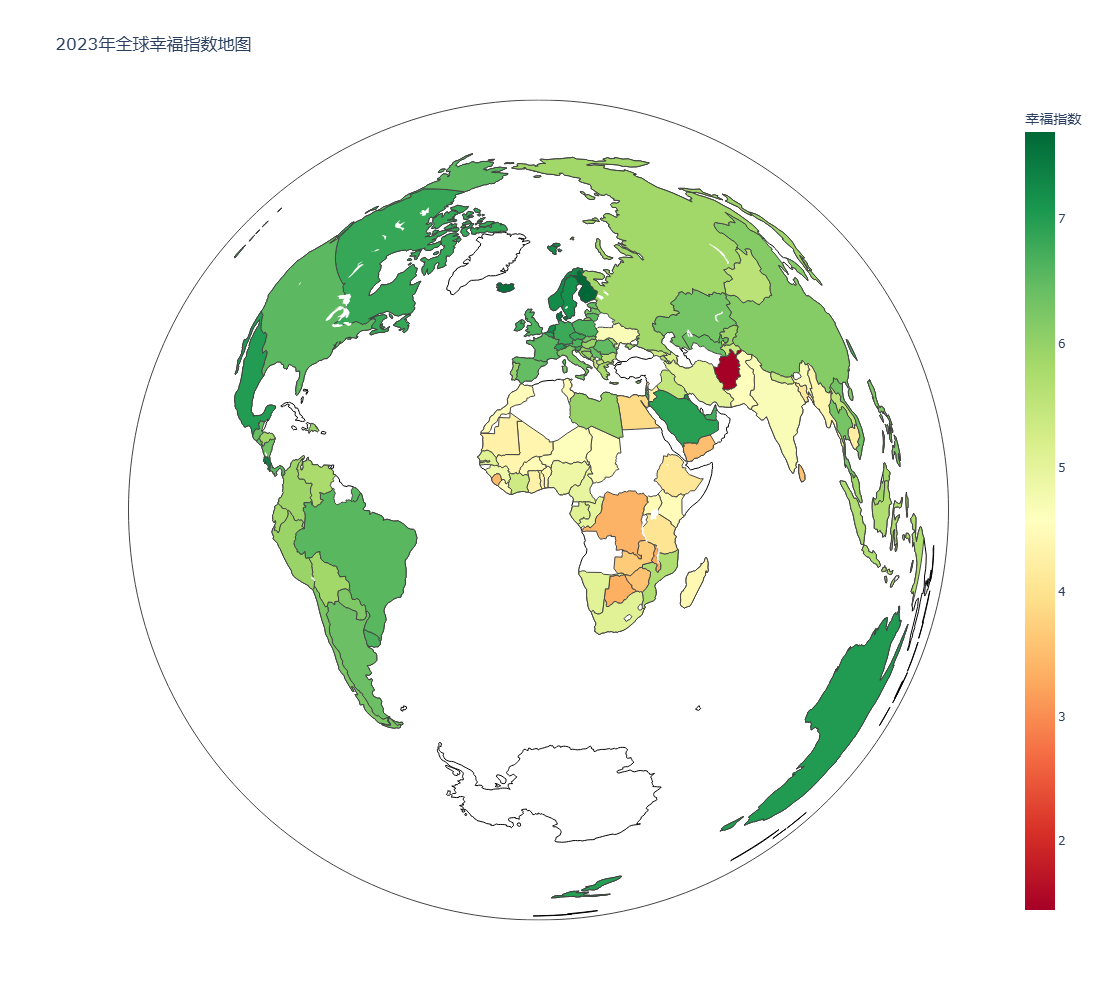

In [474]:
# 初始化Plotly notebook模式
init_notebook_mode(connected=True)

data_2023 = final_data[final_data['年份'] == 2023]

# 创建choropleth图的数据字典
data = dict(
    type='choropleth',
    locations=data_2023['国家/地区'],  # 使用实际的国家名称列表
    locationmode='country names',  # 设置为使用国家名称匹配
    colorscale='RdYlGn',  # 颜色比例尺
    z=data_2023['幸福指数'],  # Z值对应于颜色的比例尺
    text=data_2023['国家/地区'],  # 文本信息显示在悬停时
    colorbar={'title': '幸福指数'}  # 颜色条标题
)

# 创建布局字典
layout = dict(
    title='2023年全球幸福指数地图',  # 图表标题
    geo=dict(
        showframe=True, 
        projection={'type': 'azimuthal equal area'},  # 设置投影类型
        scope='world',  # 设置地图显示为全球范围
        showcoastlines=True,  # 显示海岸线
        coastlinecolor='Black',  # 设置海岸线颜色
        landcolor='white',  # 设置陆地颜色
        countrycolor='black'  # 设置国家边界颜色
    ),
    width=1000,  # 设置图表宽度
    height=1000  # 设置图表高度
)

# 创建Figure对象并绘制地图
choromap3 = go.Figure(data=[data], layout=layout)

# 显示地图
choromap3.show()

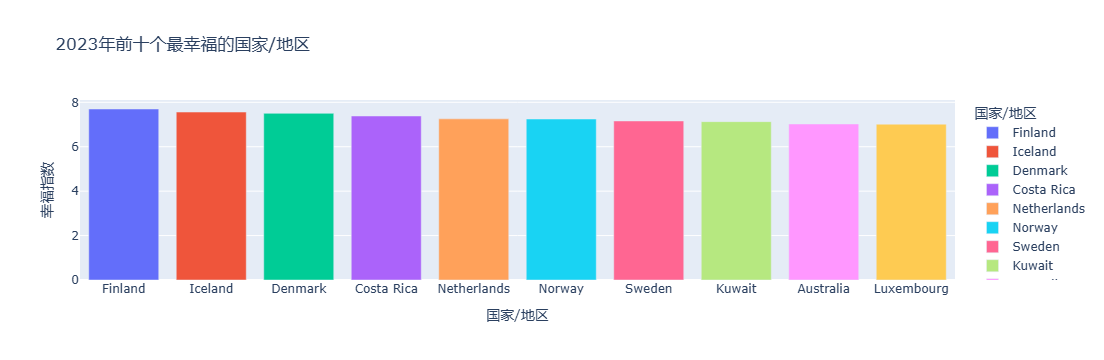

In [475]:
# 选取2023年的数据并排序，取Top 10
top_10_countries = data_2023.nlargest(10, '幸福指数')

# 创建柱状图
fig = px.bar(
    top_10_countries,
    x="国家/地区",  # X轴为国家/地区名称
    y="幸福指数",   # Y轴为幸福指数
    color="国家/地区",  # 按国家名称着色
    title="2023年前十个最幸福的国家/地区",  # 图表标题
    labels={'幸福指数': '幸福指数'},  # Y轴标签
    hover_data=['国家/地区', '幸福指数']  # 鼠标悬停时显示的数据
)

# 设置X轴和Y轴标签
fig.update_xaxes(title_text='国家/地区')
fig.update_yaxes(title_text='幸福指数')

fig.show()

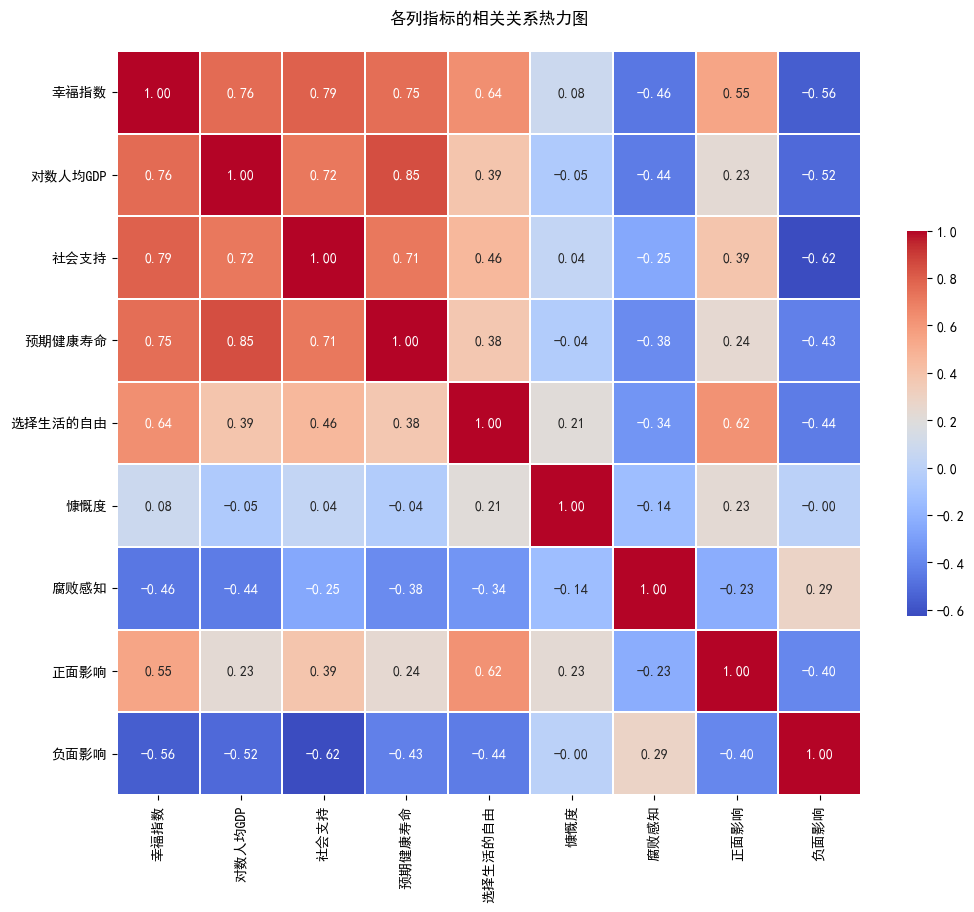

In [476]:
# 删除 'Country name' 和 'year' 列以计算其余列的相关性
data_for_correlation = data_2023.drop(['国家/地区', '年份'], axis=1)

# 计算相关矩阵
correlation_matrix = data_for_correlation.corr()

# 使用seaborn绘制热力图
plt.figure(figsize=(12, 10))  # 调整图形尺寸以适应更多的信息
heatmap = sns.heatmap(correlation_matrix, linewidths=0.1,
                      linecolor='white',annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .5},
                      annot_kws={"size": 10})  # 设置注释文本的字体大小

# 改善布局并展示标题
plt.title('各列指标的相关关系热力图', pad=20)  # 增加标题与图表之间的间距
plt.show()

### 五.Kmeans聚类

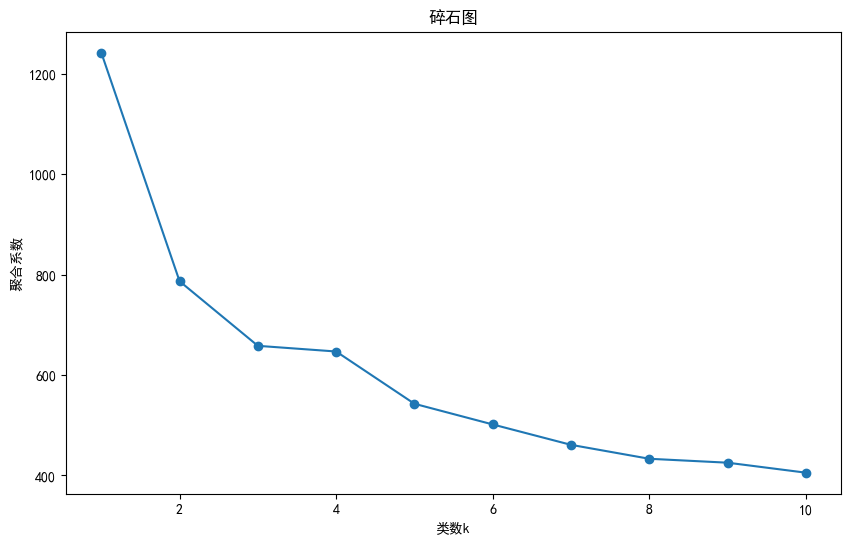

In [477]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 假设 data_2023 是您的 DataFrame，包含 'Country name' 列和其他特征列

# 1. 数据准备和预处理
# 分离出用于聚类的特征列（不包括 'Country name' 和 'year'）
data_for_clustering = data_2023.drop(['国家/地区', '年份'], axis=1)


# 标准化数据
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

# 2. 确定聚类数 k
# 使用肘部法则来找到最优的 k 值
wcss = []  # Within-Cluster-Sum-of-Squares
for i in range(1, 11):
    os.environ['OMP_NUM_THREADS'] = '1'  # 设置环境变量以避免MKL内存泄漏
    kmeans = KMeans(n_clusters=i, init='k-means++',n_init='auto',random_state=40)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示为方块的问题

# 绘制聚合系数图以帮助选择最佳 k 值
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('碎石图')
plt.xlabel('类数k')
plt.ylabel('聚合系数')
plt.show()

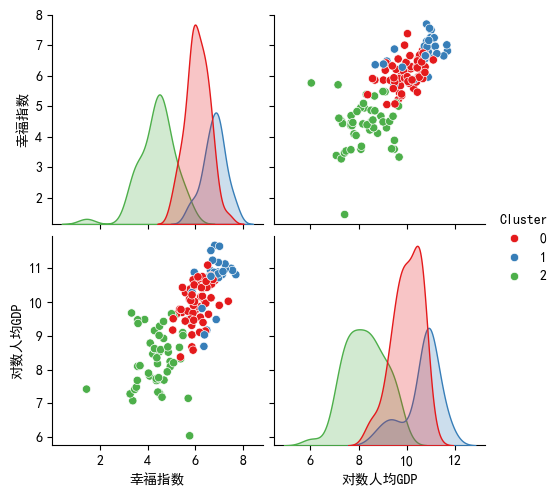

In [478]:
# 根据肘部图选择一个合适的 k 值，比如 k=3 或者根据实际情况调整
optimal_k = 3  # 这里假设选择了3个簇作为例子
# 3. 应用 KMeans 聚类
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', n_init='auto',random_state=23)
clusters = kmeans.fit_predict(scaled_data)

# 将聚类结果添加到原始数据框中
data_with_clusters = data_2023.copy()  # 创建副本以保留原始数据
data_with_clusters['Cluster'] = clusters

# 4. 可视化聚类结果与国家名称对应

# 使用pairplot展示两个特征，并通过hue参数区分不同的簇
sns.pairplot(data=data_with_clusters, hue='Cluster', vars=data_for_clustering.columns[:2], palette='Set1')

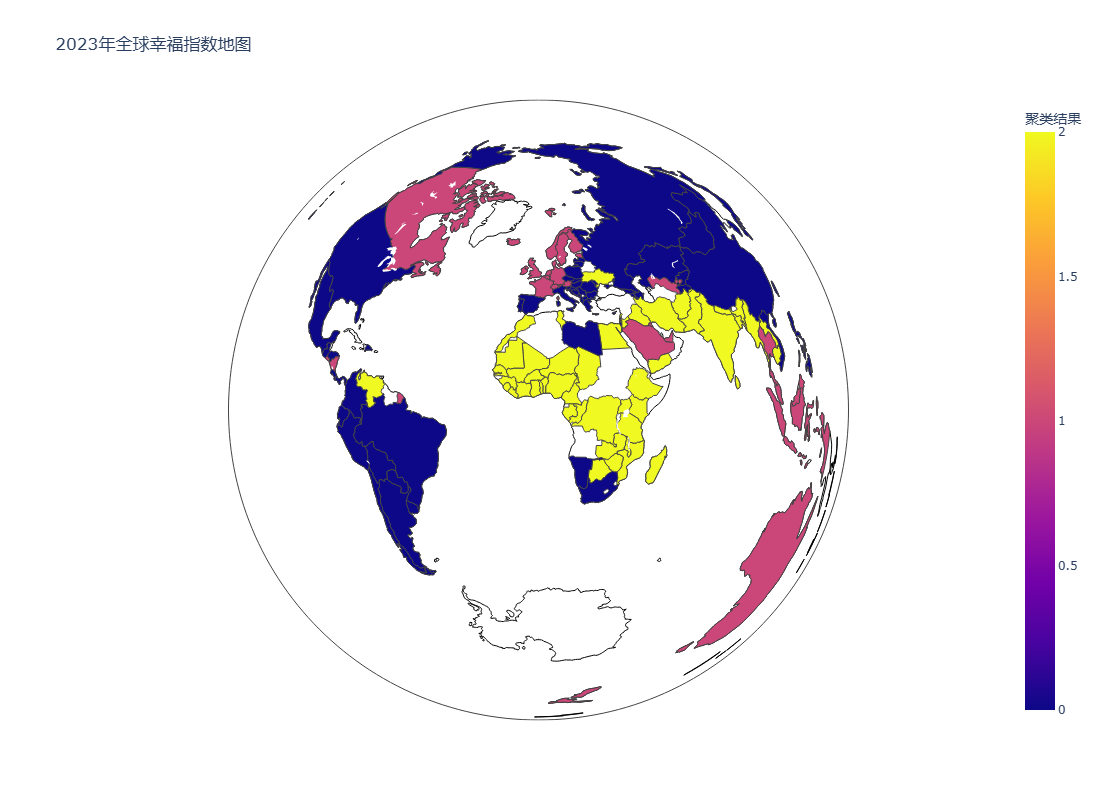

In [479]:
# 初始化Plotly notebook模式
init_notebook_mode(connected=True)

# 创建choropleth图的数据字典
dict2 = dict(
    type='choropleth',
    locations=data_with_clusters['国家/地区'],  # 使用实际的国家名称列表
    locationmode='country names',  # 设置为使用国家名称匹配 
    z=data_with_clusters['Cluster'],  # Z值对应于颜色的比例尺
    text=data_with_clusters['国家/地区'],  # 文本信息显示在悬停时
    colorbar={'title': '聚类结果'}  # 颜色条标题
)

# 创建布局字典
layout = dict(
    title='2023年全球幸福指数地图',  # 图表标题
    geo=dict(
        showframe=True, 
        projection={'type': 'azimuthal equal area'},  # 设置投影类型
        scope='world',  # 设置地图显示为全球范围
        showcoastlines=True,  # 显示海岸线
        coastlinecolor='Black',  # 设置海岸线颜色
        landcolor='white',  # 设置陆地颜色
        countrycolor='black'  # 设置国家边界颜色
    ),
    width=1000,  # 设置图表宽度
    height=800  # 设置图表高度
)

# 创建Figure对象并绘制地图
choromap4 = go.Figure(data=[dict2], layout=layout)



choromap4.show()

### 六.建立Country类和对应的Xgboost、DNN模型

In [480]:
# 2. 特征标准化
def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# 3. XGBoost模型训练
def train_xgboost(X_train, y_train):
    # 定义模型
    model = xgb.XGBRegressor(random_state=42)

    # 定义要优化的参数范围
    param_grid = {
        'n_estimators': [50, 100, 200],  # 树的数量
        'max_depth': [3, 6, 9],          # 树的最大深度
        'learning_rate': [0.01, 0.1, 0.2],  # 学习率
        'subsample': [0.8, 1.0],         # 构建每棵树时使用的样本比例
        'colsample_bytree': [0.8, 1.0],  # 构建每棵树时使用的特征比例
        'gamma': [0, 0.1, 0.2],          # 在节点分裂时所需的最小损失函数下降值
        'reg_alpha': [0, 0.1],           # L1 正则化项权重
        'reg_lambda': [1, 1.5]           # L2 正则化项权重
    }

    # 使用 GridSearchCV 进行参数搜索
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
    
    # 训练模型
    grid_search.fit(X_train, y_train)

    # 打印最佳参数
    print("最优参数为: ", grid_search.best_params_)
    
    # 返回最佳模型
    return grid_search.best_estimator_

# 4. PyTorch 神经网络模型
class DNNModel(nn.Module):
    def __init__(self, input_dim):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# 训练神经网络
def train_pytorch_model(X_train, y_train, input_dim, epochs=100, batch_size=32, lr=0.001):
    model = DNNModel(input_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        
        loss.backward()
        optimizer.step()
    
    return model

# 评估模型
def evaluate_model(model, X_test, y_test, model_type='xgboost'):
    if model_type == 'xgboost':
        y_pred = model.predict(X_test)
    elif model_type == 'pytorch':
        model.eval()
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_pred_tensor = model(X_test_tensor)
        y_pred = y_pred_tensor.detach().numpy()

    mse = mean_squared_error(y_test, y_pred)
    return mse, y_pred

In [454]:
class Country:
    def __init__(self, country_name, data, features, target):
        self.country_name = country_name
        self.data = data
        self.features = features
        self.target = target
        self.xgboost_model = None
        self.pytorch_model = None
        self.X_train_scaled = None
        self.X_test_scaled = None
        self.y_train = None
        self.y_test = None
        self.y_test_years = None  # Store years of the test set
    
    def preprocess_data(self):
        # 筛选出指定国家的数据
        country_data = self.data[self.data['国家/地区'] == self.country_name]
        country_data_clean = country_data[self.features + [self.target, '年份']]
        X = country_data_clean[self.features]
        y = country_data_clean[self.target]
        
        # 通过train_test_split划分训练集和测试集
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # 保证y_test_years仅包含测试集对应的年份
        self.y_test_years = country_data_clean.loc[X_test.index, '年份'].values  # 使用X_test索引对齐年份
        
        # 特征标准化
        self.X_train_scaled, self.X_test_scaled = scale_features(X_train, X_test)
        self.y_train, self.y_test = y_train, y_test

    def train_xgboost_model(self):
        # 确保数据已经预处理
        if self.X_train_scaled is None or self.y_train is None:
            print("Data has not been preprocessed. Preprocessing data now...")
            self.preprocess_data()  # 如果数据未预处理，先执行预处理

        # 训练XGBoost模型
        self.xgboost_model = train_xgboost(self.X_train_scaled, self.y_train)
    
    def train_pytorch_model(self):
        # 确保数据已经预处理
        if self.X_train_scaled is None or self.y_train is None:
            print("Data has not been preprocessed. Preprocessing data now...")
            self.preprocess_data()  # 如果数据未预处理，先执行预处理

        # 训练PyTorch神经网络模型
        self.pytorch_model = train_pytorch_model(self.X_train_scaled, self.y_train, input_dim=self.X_train_scaled.shape[1])
    
    def evaluate_models(self):
        # 确保模型已训练
        if self.xgboost_model is None or self.pytorch_model is None:
            print("Models have not been trained yet. Training models now...")
        try:
            self.train_xgboost_model()
        except Exception as e:
            print(f"An error occurred during XGBoost model training: {e}")
            raise  # 如果需要将异常传递给调用者
        try:
            self.train_pytorch_model()
        except Exception as e:
            print(f"An error occurred during DNN model training: {e}")
            raise  # 如果需要将异常传递给调用者

        # XGBoost模型评估
        mse_xgboost, y_pred_xgboost = evaluate_model(self.xgboost_model, self.X_test_scaled, self.y_test, model_type='xgboost')
        print(f"使用XGBoost模型预测{self.country_name}的MSE为: {mse_xgboost}")

        # PyTorch模型评估
        mse_pytorch, y_pred_pytorch = evaluate_model(self.pytorch_model, self.X_test_scaled, self.y_test, model_type='pytorch')
        print(f"使用DNN模型预测{self.country_name}的MSE为: {mse_pytorch}")
        
        return mse_xgboost, y_pred_xgboost, mse_pytorch, y_pred_pytorch

    def get_test_predictions(self):
        # 输出测试集的年份、预测值和真实值
        if self.xgboost_model:
            _, y_pred_xgboost = evaluate_model(self.xgboost_model, self.X_test_scaled, self.y_test, model_type='xgboost')
            xgboost_results = pd.DataFrame({
                '年份': self.y_test_years,
                '真实值': self.y_test.values,
                '预测值': y_pred_xgboost
            })
            print(f"XGBoost Test Results for {self.country_name}:")
            print(xgboost_results)
        
        if self.pytorch_model:
            # 确保y_pred_pytorch是一个一维数组
            _, y_pred_pytorch = evaluate_model(self.pytorch_model, self.X_test_scaled, self.y_test, model_type='pytorch')
            y_pred_pytorch = y_pred_pytorch.flatten()  # 将预测结果展平成一维数组
            y_test_flat = self.y_test.values.flatten()  # 将真实值展平成一维数组
    
            pytorch_results = pd.DataFrame({
                '年份': self.y_test_years,
                '真实值': y_test_flat,
                '预测值': y_pred_pytorch
            })
            print(f"DNN Test Results for {self.country_name}:")
            print(pytorch_results)

### 七.对三个国家进行预测，分析模型的优劣性

In [455]:
# 6. 运行流程：使用“美国”作为例子
features = ['对数人均GDP','社会支持','预期寿命','选择生活的自由','慷慨度','腐败感知','正面影响','负面影响']
target = '幸福指数'

# 创建一个Country实例
country_name = 'United States'  # 假设我们选择美国
country = Country(country_name, final_data, features, target)

# 训练XGBoost模型
country.train_xgboost_model()

# 训练PyTorch神经网络模型
country.train_pytorch_model()

# 评估两个模型的性能
country.evaluate_models()

# 获取并输出测试集的年份、真实值和预测值
country.get_test_predictions()

Data has not been preprocessed. Preprocessing data now...
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
最优参数为:  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
使用XGBoost模型预测United States的MSE为: 0.05053823445111073
使用DNN模型预测United States的MSE为: 6.970703903451683
XGBoost Test Results for United States:
     年份       真实值       预测值
0  2006  7.181794  7.171680
1  2007  7.512688  7.110421
2  2014  7.151114  6.950538
3  2011  7.115139  7.114199
DNN Test Results for United States:
     年份       真实值        预测值
0  2006  7.181794  12.019877
1  2007  7.512688   7.952262
2  2014  7.151114   8.374150
3  2011  7.115139   5.445792


In [456]:
# 创建一个Country实例
country_name = 'United Kingdom'  # 假设我们选择美国
country = Country(country_name, final_data, features, target)

# 训练XGBoost模型
country.train_xgboost_model()

# 训练PyTorch神经网络模型
country.train_pytorch_model()

# 评估两个模型的性能
country.evaluate_models()

# 获取并输出测试集的年份、真实值和预测值
country.get_test_predictions()

Data has not been preprocessed. Preprocessing data now...
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
最优参数为:  {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}
使用XGBoost模型预测United Kingdom的MSE为: 0.010262419561651576
使用DNN模型预测United Kingdom的MSE为: 17.192602454985934
XGBoost Test Results for United Kingdom:
     年份       真实值       预测值
0  2005  6.983557  6.908302
1  2007  6.801931  6.908302
2  2014  6.758148  6.908302
3  2011  6.869249  6.908302
DNN Test Results for United Kingdom:
     年份       真实值        预测值
0  2005  6.983557  14.546076
1  2007  6.801931   7.099245
2  2014  6.758148   3.970094
3  2011  6.869249   8.797221


In [457]:
# 创建一个Country实例
country_name = 'Colombia'  # 假设我们选择Colombia
country = Country(country_name, final_data, features, target)

# 训练XGBoost模型
country.train_xgboost_model()

# 训练PyTorch神经网络模型
country.train_pytorch_model()

# 评估两个模型的性能
country.evaluate_models()

# 获取并输出测试集的年份、真实值和预测值
country.get_test_predictions()

Data has not been preprocessed. Preprocessing data now...
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
最优参数为:  {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
使用XGBoost模型预测Colombia的MSE为: 0.021298877084076975
使用DNN模型预测Colombia的MSE为: 0.9952941448475487
XGBoost Test Results for Colombia:
     年份       真实值       预测值
0  2006  6.024943  6.176419
1  2007  6.138412  6.207170
2  2014  6.448789  6.387343
3  2011  6.463953  6.232118
DNN Test Results for Colombia:
     年份       真实值       预测值
0  2006  6.024943  5.783166
1  2007  6.138412  6.136927
2  2014  6.448789  7.008257
3  2011  6.463953  4.564028
